In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):

    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)


In [3]:
class ZDT(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, xl=0, xu=1, vtype=float, **kwargs)

In [4]:
class ZDT1(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])

In [5]:
class ZDT2(ZDT):

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power((f1 * 1.0 / g), 2))

        out["F"] = anp.column_stack([f1, f2])

In [6]:
class ZDT3(ZDT):

    def _calc_pareto_front(self, n_points=100, flatten=True):
        regions = [[0, 0.0830015349],
                   [0.182228780, 0.2577623634],
                   [0.4093136748, 0.4538821041],
                   [0.6183967944, 0.6525117038],
                   [0.8233317983, 0.8518328654]]

        pf = []

        for r in regions:
            x1 = np.linspace(r[0], r[1], int(n_points / len(regions)))
            x2 = 1 - np.sqrt(x1) - x1 * np.sin(10 * np.pi * x1)
            pf.append(np.array([x1, x2]).T)

        if not flatten:
            pf = np.concatenate([pf[None,...] for pf in pf])
        else:
            pf = np.row_stack(pf)

        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        c = anp.sum(x[:, 1:], axis=1)
        g = 1.0 + 9.0 * c / (self.n_var - 1)
        f2 = g * (1 - anp.power(f1 * 1.0 / g, 0.5) - (f1 * 1.0 / g) * anp.sin(10 * anp.pi * f1))

        out["F"] = anp.column_stack([f1, f2])

In [7]:
class ZDT4(ZDT):
    def __init__(self, n_var=10):
        super().__init__(n_var)
        self.xl = -5 * np.ones(self.n_var)
        self.xl[0] = 0.0
        self.xu = 5 * np.ones(self.n_var)
        self.xu[0] = 1.0
        self.func = self._evaluate

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1.0
        g += 10 * (self.n_var - 1)
        for i in range(1, self.n_var):
            g += x[:, i] * x[:, i] - 10.0 * anp.cos(4.0 * anp.pi * x[:, i])
        h = 1.0 - anp.sqrt(f1 / g)
        f2 = g * h

        out["F"] = anp.column_stack([f1, f2])

In [8]:
class ZDT5(ZDT):

    def __init__(self, m=11, n=5, normalize=True, **kwargs):
        self.m = m
        self.n = n
        self.normalize = normalize
        super().__init__(n_var=(30 + n * (m - 1)), **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = 1 + np.linspace(0, 1, n_pareto_points) * 30
        pf = np.column_stack([x, (self.m-1) / x])
        if self.normalize:
            pf = normalize(pf)
        return pf

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.astype(float)

        _x = [x[:, :30]]
        for i in range(self.m - 1):
            _x.append(x[:, 30 + i * self.n: 30 + (i + 1) * self.n])

        u = anp.column_stack([x_i.sum(axis=1) for x_i in _x])
        v = (2 + u) * (u < self.n) + 1 * (u == self.n)
        g = v[:, 1:].sum(axis=1)

        f1 = 1 + u[:, 0]
        f2 = g * (1 / f1)

        if self.normalize:
            f1 = normalize(f1, 1, 31)
            f2 = normalize(f2, (self.m-1) * 1/31, (self.m-1))

        out["F"] = anp.column_stack([f1, f2])

In [9]:
class ZDT6(ZDT):

    def __init__(self, n_var=10, **kwargs):
        super().__init__(n_var=n_var, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0.2807753191, 1, n_pareto_points)
        return np.array([x, 1 - np.power(x, 2)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 1 - anp.exp(-4 * x[:, 0]) * anp.power(anp.sin(6 * anp.pi * x[:, 0]), 6)
        g = 1 + 9.0 * anp.power(anp.sum(x[:, 1:], axis=1) / (self.n_var - 1.0), 0.25)
        f2 = g * (1 - anp.power(f1 / g, 2))

        out["F"] = anp.column_stack([f1, f2])

In [10]:
NOBJ = 2
MU = 100
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)


algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

## ZDT 1

In [11]:
NDIM = 3
problem = ZDT1(n_var=NDIM)

In [12]:
with open('pymoo_time_nsga2_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
        writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0259671211
     2 |      200 |  0.0344498158
     3 |      300 |  0.0434641838
     4 |      400 |  0.0524017811
     5 |      500 |  0.0614156723
     6 |      600 |  0.0683987141
     7 |      700 |  0.0753784180
     8 |      800 |  0.0813620090
     9 |      900 |  0.0883495808
    10 |     1000 |  0.0943300724
    11 |     1100 |  0.1013150215
    12 |     1200 |  0.1072945595
    13 |     1300 |  0.1142752171
    14 |     1400 |  0.1202642918
    15 |     1500 |  0.1272394657
    16 |     1600 |  0.1332237720
    17 |     1700 |  0.1392145157
    18 |     1800 |  0.1451909542
    19 |     1900 |  0.1511824131
    20 |     2000 |  0.1581189632
    21 |     2100 |  0.1641027927
    22 |     2200 |  0.1710860729
    23 |     2300 |  0.1780672073
    24 |     2400 |  0.1850485802
    25 |     2500 |  0.1910331249
    26 |     2600 |  0.1990113258
    27 |     2700 |  0.2049956322
    28 |     2800 |  0.2119767666
    29 |     2

   248 |    24800 |  1.7528522015
   249 |    24900 |  1.7618672848
   250 |    25000 |  1.7727982998
   251 |    25100 |  1.7788214684
   252 |    25200 |  1.7848110199
   253 |    25300 |  1.7917892933
   254 |    25400 |  1.7977695465
   255 |    25500 |  1.8037557602
   256 |    25600 |  1.8137295246
   257 |    25700 |  1.8197128773
   258 |    25800 |  1.8256964684
   259 |    25900 |  1.8316824436
   260 |    26000 |  1.8376667500
   261 |    26100 |  1.8446452618
   262 |    26200 |  1.8506307602
   263 |    26300 |  1.8566186428
   264 |    26400 |  1.8626003265
   265 |    26500 |  1.8685886860
   266 |    26600 |  1.8745932579
   267 |    26700 |  1.8805494308
   268 |    26800 |  1.8865365982
   269 |    26900 |  1.8935186863
   270 |    27000 |  1.8995325565
   271 |    27100 |  1.9054450989
   272 |    27200 |  1.9154186249
   273 |    27300 |  1.9233949184
   274 |    27400 |  1.9293785095
   275 |    27500 |  1.9354000092
   276 |    27600 |  1.9423866272
   277 |    27

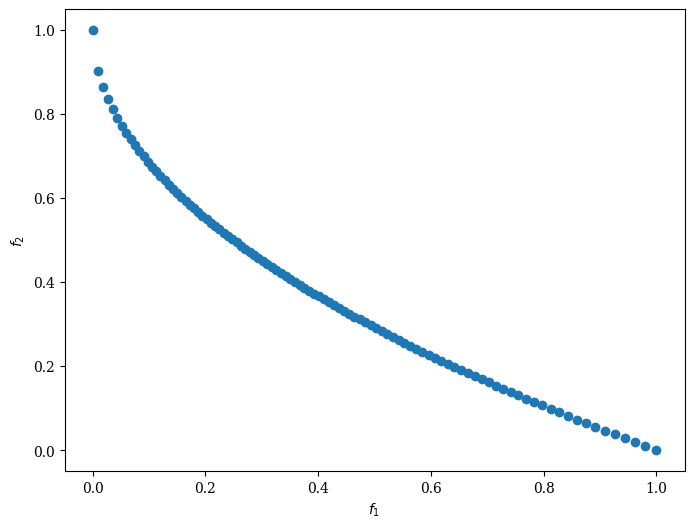

In [17]:
Scatter().add(res.F).show()

In [13]:
with open('pymoo_time_nsga3_zdt1_100_500_2_3.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt1_100_500_2_3.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0149595737
     2 |      200 |  0.0259289742
     3 |      300 |  0.0368995667
     4 |      400 |  0.0458781719
     5 |      500 |  0.0548894405
     6 |      600 |  0.0648276806
     7 |      700 |  0.0738031864
     8 |      800 |  0.0837764740
     9 |      900 |  0.0937497616
    10 |     1000 |  0.1037225723
    11 |     1100 |  0.1136963367
    12 |     1200 |  0.1236696243
    13 |     1300 |  0.1336410046
    14 |     1400 |  0.1436138153
    15 |     1500 |  0.1525900364
    16 |     1600 |  0.1615657806
    17 |     1700 |  0.1715390682
    18 |     1800 |  0.1805171967
    19 |     1900 |  0.1914880276
    20 |     2000 |  0.2024588585
    21 |     2100 |  0.2134296894
    22 |     2200 |  0.2243998051
    23 |     2300 |  0.2363665104
    24 |     2400 |  0.2523653507
    25 |     2500 |  0.2652881145
    26 |     2600 |  0.2753126621
    27 |     2700 |  0.2862696648
    28 |     2800 |  0.2966883183
    29 |     2

   242 |    24200 |  2.6379792690
   243 |    24300 |  2.6509430408
   244 |    24400 |  2.6628746986
   245 |    24500 |  2.6738438606
   246 |    24600 |  2.6858119965
   247 |    24700 |  2.6967828274
   248 |    24800 |  2.7087504864
   249 |    24900 |  2.7207190990
   250 |    25000 |  2.7316892147
   251 |    25100 |  2.7436573505
   252 |    25200 |  2.7546281815
   253 |    25300 |  2.7665958405
   254 |    25400 |  2.7785637379
   255 |    25500 |  2.7895343304
   256 |    25600 |  2.8025007248
   257 |    25700 |  2.8135092258
   258 |    25800 |  2.8294725418
   259 |    25900 |  2.8403992653
   260 |    26000 |  2.8563554287
   261 |    26100 |  2.8713159561
   262 |    26200 |  2.8813259602
   263 |    26300 |  2.8923013210
   264 |    26400 |  2.9072175026
   265 |    26500 |  2.9222168922
   266 |    26600 |  2.9381361008
   267 |    26700 |  2.9520974159
   268 |    26800 |  2.9630680084
   269 |    26900 |  2.9730412960
   270 |    27000 |  2.9850096703
   271 |    27

   492 |    49200 |  5.4816527367
   493 |    49300 |  5.4966139793
   494 |    49400 |  5.5065863132
   495 |    49500 |  5.5175573826
   496 |    49600 |  5.5275719166
   497 |    49700 |  5.5385420322
   498 |    49800 |  5.5494730473
   499 |    49900 |  5.5614411831
   500 |    50000 |  5.5724451542


## ZDT 2

In [ ]:
NDIM = 4
problem = ZDT2(n_var=NDIM)

In [16]:
with open('pymoo_time_nsga2_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0127997398
     2 |      200 |  0.0189175606
     3 |      300 |  0.0341627598
     4 |      400 |  0.0421190262
     5 |      500 |  0.0515344143
     6 |      600 |  0.0585150719
     7 |      700 |  0.0665736198
     8 |      800 |  0.0665736198
     9 |      900 |  0.0821955204
    10 |     1000 |  0.0821955204
    11 |     1100 |  0.0957500935
    12 |     1200 |  0.0957500935
    13 |     1300 |  0.1113774776
    14 |     1400 |  0.1113774776
    15 |     1500 |  0.1113774776
    16 |     1600 |  0.1270425320
    17 |     1700 |  0.1270425320
    18 |     1800 |  0.1426734924
    19 |     1900 |  0.1426734924
    20 |     2000 |  0.1582801342
    21 |     2100 |  0.1582801342
    22 |     2200 |  0.1582801342
    23 |     2300 |  0.1739065647
    24 |     2400 |  0.1739065647
    25 |     2500 |  0.1895239353
    26 |     2600 |  0.1960773468
    27 |     2700 |  0.1960773468
    28 |     2800 |  0.2117538452
    29 |     2

   259 |    25900 |  1.7516489029
   260 |    26000 |  1.7631375790
   261 |    26100 |  1.7706956863
   262 |    26200 |  1.7766773701
   263 |    26300 |  1.7842278481
   264 |    26400 |  1.7901821136
   265 |    26500 |  1.7961976528
   266 |    26600 |  1.8028652668
   267 |    26700 |  1.8088500500
   268 |    26800 |  1.8158302307
   269 |    26900 |  1.8168642521
   270 |    27000 |  1.8168642521
   271 |    27100 |  1.8325266838
   272 |    27200 |  1.8325266838
   273 |    27300 |  1.8325266838
   274 |    27400 |  1.8481581211
   275 |    27500 |  1.8481581211
   276 |    27600 |  1.8637766838
   277 |    27700 |  1.8637766838
   278 |    27800 |  1.8708546162
   279 |    27900 |  1.8708546162
   280 |    28000 |  1.8865239620
   281 |    28100 |  1.8865239620
   282 |    28200 |  1.8865239620
   283 |    28300 |  1.9021432400
   284 |    28400 |  1.9177589417
   285 |    28500 |  1.9177589417
   286 |    28600 |  1.9333446026
   287 |    28700 |  1.9333446026
   288 |    28

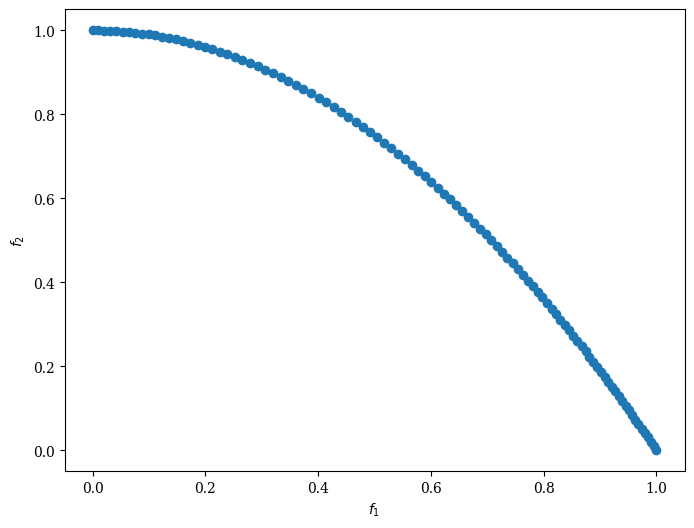

In [23]:
Scatter().add(res.F).show()

In [17]:
with open('pymoo_time_nsga3_zdt2_100_500_2_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt2_100_500_2_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])

    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)

    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0084128380
     2 |      200 |  0.0102736950
     3 |      300 |  0.0252618790
     4 |      400 |  0.0252618790
     5 |      500 |  0.0497035980
     6 |      600 |  0.0596764088
     7 |      700 |  0.0686521530
     8 |      800 |  0.0766596794
     9 |      900 |  0.0766596794
    10 |     1000 |  0.0923252106
    11 |     1100 |  0.0923252106
    12 |     1200 |  0.1079499722
    13 |     1300 |  0.1079499722
    14 |     1400 |  0.1235680580
    15 |     1500 |  0.1392199993
    16 |     1600 |  0.1457755566
    17 |     1700 |  0.1457755566
    18 |     1800 |  0.1614427567
    19 |     1900 |  0.1614427567
    20 |     2000 |  0.1770222187
    21 |     2100 |  0.1926460266
    22 |     2200 |  0.1926460266
    23 |     2300 |  0.2082693577
    24 |     2400 |  0.2082693577
    25 |     2500 |  0.2354249954
    26 |     2600 |  0.2460119724
    27 |     2700 |  0.2603480816
    28 |     2800 |  0.2693176270
    29 |     2

   246 |    24600 |  2.6199271679
   247 |    24700 |  2.6382522583
   248 |    24800 |  2.6503732204
   249 |    24900 |  2.6604764462
   250 |    25000 |  2.6704559326
   251 |    25100 |  2.6810667515
   252 |    25200 |  2.6920380592
   253 |    25300 |  2.6931178570
   254 |    25400 |  2.7087411880
   255 |    25500 |  2.7087411880
   256 |    25600 |  2.7243654728
   257 |    25700 |  2.7399864197
   258 |    25800 |  2.7399864197
   259 |    25900 |  2.7606482506
   260 |    26000 |  2.7606482506
   261 |    26100 |  2.7763144970
   262 |    26200 |  2.7918961048
   263 |    26300 |  2.7918961048
   264 |    26400 |  2.8075635433
   265 |    26500 |  2.8231863976
   266 |    26600 |  2.8424994946
   267 |    26700 |  2.8525116444
   268 |    26800 |  2.8624901772
   269 |    26900 |  2.8724668026
   270 |    27000 |  2.8764810562
   271 |    27100 |  2.8921501637
   272 |    27200 |  2.8921501637
   273 |    27300 |  2.9077718258
   274 |    27400 |  2.9233922958
   275 |    27

   499 |    49900 |  5.3918399811
   500 |    50000 |  5.4106695652


## ZDT 3

In [18]:
NDIM = 5
problem = ZDT3(n_var=NDIM)

In [19]:
with open('pymoo_time_nsga2_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0112507343
     2 |      200 |  0.0137588978
     3 |      300 |  0.0261995792
     4 |      400 |  0.0261995792
     5 |      500 |  0.0501546860
     6 |      600 |  0.0571358204
     7 |      700 |  0.0651946068
     8 |      800 |  0.0711841583
     9 |      900 |  0.0771925449
    10 |     1000 |  0.0771925449
    11 |     1100 |  0.0771925449
    12 |     1200 |  0.0928528309
    13 |     1300 |  0.0928528309
    14 |     1400 |  0.1084830761
    15 |     1500 |  0.1084830761
    16 |     1600 |  0.1241042614
    17 |     1700 |  0.1241042614
    18 |     1800 |  0.1241042614
    19 |     1900 |  0.1397261620
    20 |     2000 |  0.1397261620
    21 |     2100 |  0.1553452015
    22 |     2200 |  0.1553452015
    23 |     2300 |  0.1553452015
    24 |     2400 |  0.1703591347
    25 |     2500 |  0.1703591347
    26 |     2600 |  0.1860289574
    27 |     2700 |  0.1860289574
    28 |     2800 |  0.2016477585
    29 |     2

   258 |    25800 |  1.7257816792
   259 |    25900 |  1.7367520332
   260 |    26000 |  1.7427954674
   261 |    26100 |  1.7427954674
   262 |    26200 |  1.7427954674
   263 |    26300 |  1.7645332813
   264 |    26400 |  1.7715144157
   265 |    26500 |  1.7786693573
   266 |    26600 |  1.7856509686
   267 |    26700 |  1.7926325798
   268 |    26800 |  1.7937064171
   269 |    26900 |  1.7937064171
   270 |    27000 |  1.8093307018
   271 |    27100 |  1.8093307018
   272 |    27200 |  1.8093307018
   273 |    27300 |  1.8249552250
   274 |    27400 |  1.8249552250
   275 |    27500 |  1.8405771255
   276 |    27600 |  1.8405771255
   277 |    27700 |  1.8405771255
   278 |    27800 |  1.8561980724
   279 |    27900 |  1.8561980724
   280 |    28000 |  1.8718194962
   281 |    28100 |  1.8738288879
   282 |    28200 |  1.8738288879
   283 |    28300 |  1.8894603252
   284 |    28400 |  1.8894603252
   285 |    28500 |  1.8894603252
   286 |    28600 |  1.9050817490
   287 |    28

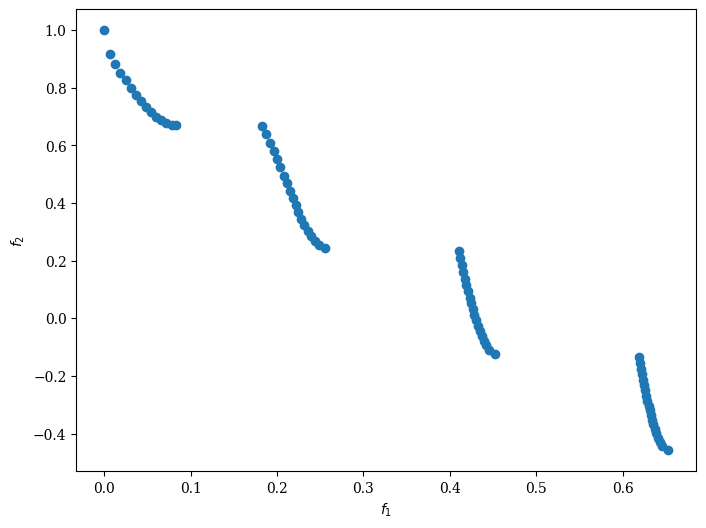

In [30]:
Scatter().add(res.F).show()

In [20]:
with open('pymoo_time_nsga3_zdt3_100_500_2_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt3_100_500_2_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])

    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)

    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0081174374
     2 |      200 |  0.0215470791
     3 |      300 |  0.0219249725
     4 |      400 |  0.0401964188
     5 |      500 |  0.0491666794
     6 |      600 |  0.0591318607
     7 |      700 |  0.0680644512
     8 |      800 |  0.0731327534
     9 |      900 |  0.0841836929
    10 |     1000 |  0.0841836929
    11 |     1100 |  0.0998544693
    12 |     1200 |  0.0998544693
    13 |     1300 |  0.1154797077
    14 |     1400 |  0.1310944557
    15 |     1500 |  0.1310944557
    16 |     1600 |  0.1467154026
    17 |     1700 |  0.1467154026
    18 |     1800 |  0.1623394489
    19 |     1900 |  0.1779606342
    20 |     2000 |  0.1845138073
    21 |     2100 |  0.1845138073
    22 |     2200 |  0.2002182007
    23 |     2300 |  0.2002182007
    24 |     2400 |  0.2285819054
    25 |     2500 |  0.2422695160
    26 |     2600 |  0.2512454987
    27 |     2700 |  0.2652311325
    28 |     2800 |  0.2714266777
    29 |     2

   248 |    24800 |  2.5909385681
   249 |    24900 |  2.6120376587
   250 |    25000 |  2.6223628521
   251 |    25100 |  2.6333777905
   252 |    25200 |  2.6433475018
   253 |    25300 |  2.6553161144
   254 |    25400 |  2.6563911438
   255 |    25500 |  2.6720154285
   256 |    25600 |  2.6720154285
   257 |    25700 |  2.6876373291
   258 |    25800 |  2.7032604218
   259 |    25900 |  2.7032604218
   260 |    26000 |  2.7188806534
   261 |    26100 |  2.7303938866
   262 |    26200 |  2.7460229397
   263 |    26300 |  2.7460229397
   264 |    26400 |  2.7616453171
   265 |    26500 |  2.7772669792
   266 |    26600 |  2.7772669792
   267 |    26700 |  2.7928876877
   268 |    26800 |  2.8115065098
   269 |    26900 |  2.8214800358
   270 |    27000 |  2.8305532932
   271 |    27100 |  2.8440907001
   272 |    27200 |  2.8550305367
   273 |    27300 |  2.8660027981
   274 |    27400 |  2.8730697632
   275 |    27500 |  2.8730697632
   276 |    27600 |  2.8886935711
   277 |    27

   491 |    49100 |  5.1810121536
   492 |    49200 |  5.1939744949
   493 |    49300 |  5.2049462795
   494 |    49400 |  5.2229013443
   495 |    49500 |  5.2368600368
   496 |    49600 |  5.2498261929
   497 |    49700 |  5.2617936134
   498 |    49800 |  5.2757582664
   499 |    49900 |  5.2857306004
   500 |    50000 |  5.2997334003


## ZDT 4

In [21]:
NDIM = 7
problem = ZDT4(n_var=NDIM)

In [22]:
with open('pymoo_time_nsga2_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0098598003
     2 |      200 |  0.0281214714
     3 |      300 |  0.0284695625
     4 |      400 |  0.0463175774
     5 |      500 |  0.0532979965
     6 |      600 |  0.0616881847
     7 |      700 |  0.0696668625
     8 |      800 |  0.0786442757
     9 |      900 |  0.0797238350
    10 |     1000 |  0.0953841209
    11 |     1100 |  0.0953841209
    12 |     1200 |  0.1109712124
    13 |     1300 |  0.1109712124
    14 |     1400 |  0.1265923977
    15 |     1500 |  0.1265923977
    16 |     1600 |  0.1422133446
    17 |     1700 |  0.1452236176
    18 |     1800 |  0.1452236176
    19 |     1900 |  0.1608545780
    20 |     2000 |  0.1608545780
    21 |     2100 |  0.1764767170
    22 |     2200 |  0.1764767170
    23 |     2300 |  0.1920983791
    24 |     2400 |  0.1920983791
    25 |     2500 |  0.2077195644
    26 |     2600 |  0.2077195644
    27 |     2700 |  0.2233407497
    28 |     2800 |  0.2385694981
    29 |     2

   250 |    25000 |  1.7494914532
   251 |    25100 |  1.7628951073
   252 |    25200 |  1.7628951073
   253 |    25300 |  1.7628951073
   254 |    25400 |  1.7830617428
   255 |    25500 |  1.7890458107
   256 |    25600 |  1.7960197926
   257 |    25700 |  1.8039972782
   258 |    25800 |  1.8099820614
   259 |    25900 |  1.8130488396
   260 |    26000 |  1.8130488396
   261 |    26100 |  1.8286728859
   262 |    26200 |  1.8286728859
   263 |    26300 |  1.8286728859
   264 |    26400 |  1.8442971706
   265 |    26500 |  1.8442971706
   266 |    26600 |  1.8599135876
   267 |    26700 |  1.8599135876
   268 |    26800 |  1.8599135876
   269 |    26900 |  1.8755350113
   270 |    27000 |  1.8755350113
   271 |    27100 |  1.8911561966
   272 |    27200 |  1.8981647491
   273 |    27300 |  1.8981647491
   274 |    27400 |  1.9137907028
   275 |    27500 |  1.9137907028
   276 |    27600 |  1.9137907028
   277 |    27700 |  1.9294116497
   278 |    27800 |  1.9294116497
   279 |    27

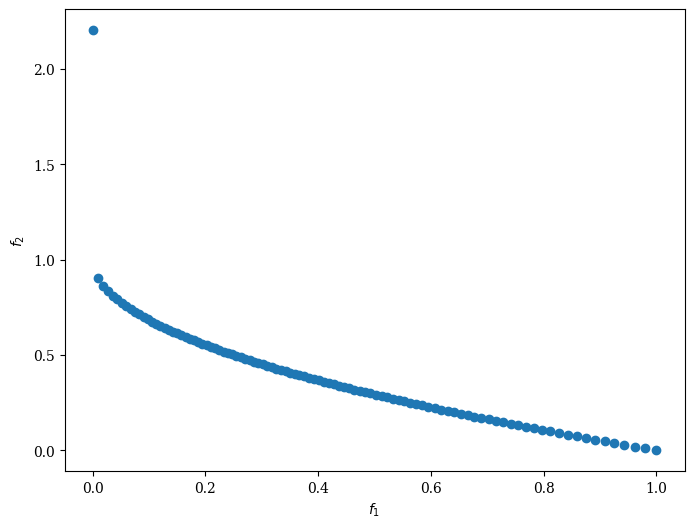

In [35]:
Scatter().add(res.F).show()

In [23]:
with open('pymoo_time_nsga3_zdt4_100_500_2_7.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt4_100_500_2_7.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0033504963
     2 |      200 |  0.0147168636
     3 |      300 |  0.0147168636
     4 |      400 |  0.0390968323
     5 |      500 |  0.0491025448
     6 |      600 |  0.0580763817
     7 |      700 |  0.0660991669
     8 |      800 |  0.0660991669
     9 |      900 |  0.0817859173
    10 |     1000 |  0.0817859173
    11 |     1100 |  0.0973911285
    12 |     1200 |  0.0973911285
    13 |     1300 |  0.1129641533
    14 |     1400 |  0.1286323071
    15 |     1500 |  0.1286323071
    16 |     1600 |  0.1462948322
    17 |     1700 |  0.1462948322
    18 |     1800 |  0.1619679928
    19 |     1900 |  0.1775887012
    20 |     2000 |  0.1874368191
    21 |     2100 |  0.1978275776
    22 |     2200 |  0.2067635059
    23 |     2300 |  0.2204120159
    24 |     2400 |  0.2311828136
    25 |     2500 |  0.2399682999
    26 |     2600 |  0.2547578812
    27 |     2700 |  0.2646920681
    28 |     2800 |  0.2737071514
    29 |     2

   242 |    24200 |  2.5969195366
   243 |    24300 |  2.6171584129
   244 |    24400 |  2.6174762249
   245 |    24500 |  2.6399261951
   246 |    24600 |  2.6503093243
   247 |    24700 |  2.6503093243
   248 |    24800 |  2.6743221283
   249 |    24900 |  2.6852154732
   250 |    25000 |  2.6961860657
   251 |    25100 |  2.6992621422
   252 |    25200 |  2.7148859501
   253 |    25300 |  2.7148859501
   254 |    25400 |  2.7305090427
   255 |    25500 |  2.7461314201
   256 |    25600 |  2.7501394749
   257 |    25700 |  2.7657659054
   258 |    25800 |  2.7657659054
   259 |    25900 |  2.7813880444
   260 |    26000 |  2.7970552444
   261 |    26100 |  2.8142971992
   262 |    26200 |  2.8243095875
   263 |    26300 |  2.8353025913
   264 |    26400 |  2.8452758789
   265 |    26500 |  2.8512637615
   266 |    26600 |  2.8672780991
   267 |    26700 |  2.8679950237
   268 |    26800 |  2.8900666237
   269 |    26900 |  2.8977267742
   270 |    27000 |  2.8977267742
   271 |    27

   495 |    49500 |  5.3945190907
   496 |    49600 |  5.4158792496
   497 |    49700 |  5.4177711010
   498 |    49800 |  5.4388022423
   499 |    49900 |  5.4488356113
   500 |    50000 |  5.4588081837


## ZDT 5

In [25]:
problem = ZDT5()
algorithm_nsga2_bin = NSGA2(pop_size=MU, 
                      sampling=BinaryRandomSampling(),
                      selection=TournamentSelection(func_comp=binary_tournament),
                      crossover=TwoPointCrossover(),
                      mutation=BitflipMutation(),
                      eliminate_duplicates=False)

algorithm_nsga3_bin = NSGA3(pop_size=MU, 
                            sampling=BinaryRandomSampling(), 
                            selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                            crossover=TwoPointCrossover(),
                            mutation=BitflipMutation(),
                            ref_dirs=ref_dirs,
                            eliminate_duplicates=False)

In [26]:
with open('pymoo_time_nsga2_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0583815575
     2 |      200 |  0.1175594330
     3 |      300 |  0.1175594330
     4 |      400 |  0.1331870556
     5 |      500 |  0.1331870556
     6 |      600 |  0.1498894691
     7 |      700 |  0.1498894691
     8 |      800 |  0.1655204296
     9 |      900 |  0.1655204296
    10 |     1000 |  0.1811416149
    11 |     1100 |  0.1811416149
    12 |     1200 |  0.1967575550
    13 |     1300 |  0.1967575550
    14 |     1400 |  0.1967575550
    15 |     1500 |  0.2123785019
    16 |     1600 |  0.2123785019
    17 |     1700 |  0.2279999256
    18 |     1800 |  0.2279999256
    19 |     1900 |  0.2436263561
    20 |     2000 |  0.2501704693
    21 |     2100 |  0.2501704693
    22 |     2200 |  0.2704141140
    23 |     2300 |  0.2840757370
    24 |     2400 |  0.2941536903
    25 |     2500 |  0.3011391163
    26 |     2600 |  0.3089878559
    27 |     2700 |  0.3170113564
    28 |     2800 |  0.3193807602
    29 |     2

   239 |    23900 |  2.0071551800
   240 |    24000 |  2.0137584209
   241 |    24100 |  2.0252737999
   242 |    24200 |  2.0332572460
   243 |    24300 |  2.0462172031
   244 |    24400 |  2.0542745590
   245 |    24500 |  2.0698971748
   246 |    24600 |  2.0698971748
   247 |    24700 |  2.0855586529
   248 |    24800 |  2.0855586529
   249 |    24900 |  2.1042385101
   250 |    25000 |  2.1042385101
   251 |    25100 |  2.1042385101
   252 |    25200 |  2.1198992729
   253 |    25300 |  2.1198992729
   254 |    25400 |  2.1355309486
   255 |    25500 |  2.1355309486
   256 |    25600 |  2.1511552334
   257 |    25700 |  2.1511552334
   258 |    25800 |  2.1667730808
   259 |    25900 |  2.1667730808
   260 |    26000 |  2.1824076176
   261 |    26100 |  2.1824076176
   262 |    26200 |  2.1980283260
   263 |    26300 |  2.2046039104
   264 |    26400 |  2.2046039104
   265 |    26500 |  2.2209737301
   266 |    26600 |  2.2309508324
   267 |    26700 |  2.2402336597
   268 |    26

   484 |    48400 |  3.9361548424
   485 |    48500 |  3.9409513474
   486 |    48600 |  3.9545831680
   487 |    48700 |  3.9625592232
   488 |    48800 |  3.9704942703
   489 |    48900 |  3.9804675579
   490 |    49000 |  3.9874918461
   491 |    49100 |  3.9874918461
   492 |    49200 |  4.0031633377
   493 |    49300 |  4.0031633377
   494 |    49400 |  4.0187795162
   495 |    49500 |  4.0187795162
   496 |    49600 |  4.0303382874
   497 |    49700 |  4.0303382874
   498 |    49800 |  4.0460073948
   499 |    49900 |  4.0460073948
   500 |    50000 |  4.0616292953


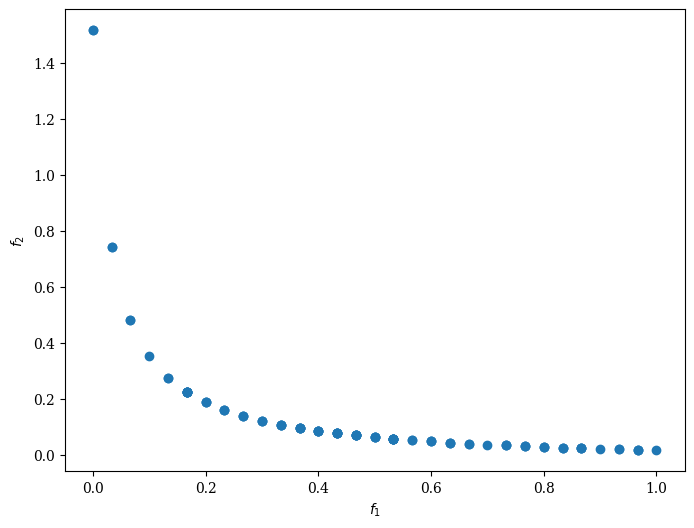

In [29]:
Scatter().add(res.F).show()

In [31]:
with open('pymoo_time_nsga3_zdt5_100_500_2_80.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt5_100_500_2_80.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3_bin, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0129644871
     2 |      200 |  0.0279266834
     3 |      300 |  0.0388967991
     4 |      400 |  0.0489056110
     5 |      500 |  0.0588414669
     6 |      600 |  0.0688533783
     7 |      700 |  0.0788259506
     8 |      800 |  0.0887989998
     9 |      900 |  0.0977754593
    10 |     1000 |  0.1067581177
    11 |     1100 |  0.1167242527
    12 |     1200 |  0.1267039776
    13 |     1300 |  0.1356799603
    14 |     1400 |  0.1456470490
    15 |     1500 |  0.1546297073
    16 |     1600 |  0.1636009216
    17 |     1700 |  0.1735799313
    18 |     1800 |  0.1835100651
    19 |     1900 |  0.1944780350
    20 |     2000 |  0.2034542561
    21 |     2100 |  0.2134273052
    22 |     2200 |  0.2234008312
    23 |     2300 |  0.2353696823
    24 |     2400 |  0.2473745346
    25 |     2500 |  0.2583100796
    26 |     2600 |  0.2672834396
    27 |     2700 |  0.2782545090
    28 |     2800 |  0.2882280350
    29 |     2

   256 |    25600 |  2.8532338142
   257 |    25700 |  2.8681552410
   258 |    25800 |  2.8791282177
   259 |    25900 |  2.8910958767
   260 |    26000 |  2.9021108150
   261 |    26100 |  2.9130761623
   262 |    26200 |  2.9230582714
   263 |    26300 |  2.9340198040
   264 |    26400 |  2.9439969063
   265 |    26500 |  2.9549677372
   266 |    26600 |  2.9649412632
   267 |    26700 |  2.9759116173
   268 |    26800 |  2.9858860970
   269 |    26900 |  2.9968557358
   270 |    27000 |  3.0068292618
   271 |    27100 |  3.0177936554
   272 |    27200 |  3.0277662277
   273 |    27300 |  3.0377504826
   274 |    27400 |  3.0487153530
   275 |    27500 |  3.0586919785
   276 |    27600 |  3.0696504116
   277 |    27700 |  3.0846223831
   278 |    27800 |  3.0956940651
   279 |    27900 |  3.1056730747
   280 |    28000 |  3.1165997982
   281 |    28100 |  3.1275703907
   282 |    28200 |  3.1375439167
   283 |    28300 |  3.1475169659
   284 |    28400 |  3.1584875584
   285 |    28

## ZDT 6

In [32]:
NDIM = 10
problem = ZDT6(n_var=NDIM)

In [33]:
with open('pymoo_time_nsga2_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', 500), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0125243664
     2 |      200 |  0.0150172710
     3 |      300 |  0.0320770741
     4 |      400 |  0.0400600433
     5 |      500 |  0.0500509739
     6 |      600 |  0.0590269566
     7 |      700 |  0.0631198883
     8 |      800 |  0.0631198883
     9 |      900 |  0.0787439346
    10 |     1000 |  0.0787439346
    11 |     1100 |  0.0943672657
    12 |     1200 |  0.0943672657
    13 |     1300 |  0.1099891663
    14 |     1400 |  0.1099891663
    15 |     1500 |  0.1256079674
    16 |     1600 |  0.1256079674
    17 |     1700 |  0.1443164349
    18 |     1800 |  0.1443164349
    19 |     1900 |  0.1599884033
    20 |     2000 |  0.1599884033
    21 |     2100 |  0.1756076813
    22 |     2200 |  0.1756076813
    23 |     2300 |  0.1912286282
    24 |     2400 |  0.1912286282
    25 |     2500 |  0.2068567276
    26 |     2600 |  0.2068567276
    27 |     2700 |  0.2260231972
    28 |     2800 |  0.2365255356
    29 |     2

   244 |    24400 |  1.7524209023
   245 |    24500 |  1.7591898441
   246 |    24600 |  1.7666335106
   247 |    24700 |  1.7707686424
   248 |    24800 |  1.7839031219
   249 |    24900 |  1.7898864746
   250 |    25000 |  1.7968606949
   251 |    25100 |  1.8028450012
   252 |    25200 |  1.8088293076
   253 |    25300 |  1.8112854958
   254 |    25400 |  1.8112854958
   255 |    25500 |  1.8269062042
   256 |    25600 |  1.8269062042
   257 |    25700 |  1.8425309658
   258 |    25800 |  1.8425309658
   259 |    25900 |  1.8581507206
   260 |    26000 |  1.8591592312
   261 |    26100 |  1.8591592312
   262 |    26200 |  1.8747861385
   263 |    26300 |  1.8747861385
   264 |    26400 |  1.8904058933
   265 |    26500 |  1.8904058933
   266 |    26600 |  1.8904058933
   267 |    26700 |  1.9060266018
   268 |    26800 |  1.9060266018
   269 |    26900 |  1.9216477871
   270 |    27000 |  1.9216477871
   271 |    27100 |  1.9373080730
   272 |    27200 |  1.9373080730
   273 |    27

   491 |    49100 |  3.6725518703
   492 |    49200 |  3.6820836067
   493 |    49300 |  3.6878399849
   494 |    49400 |  3.6985111237
   495 |    49500 |  3.7055289745
   496 |    49600 |  3.7125146389
   497 |    49700 |  3.7194917202
   498 |    49800 |  3.7254776955
   499 |    49900 |  3.7334353924
   500 |    50000 |  3.7394199371


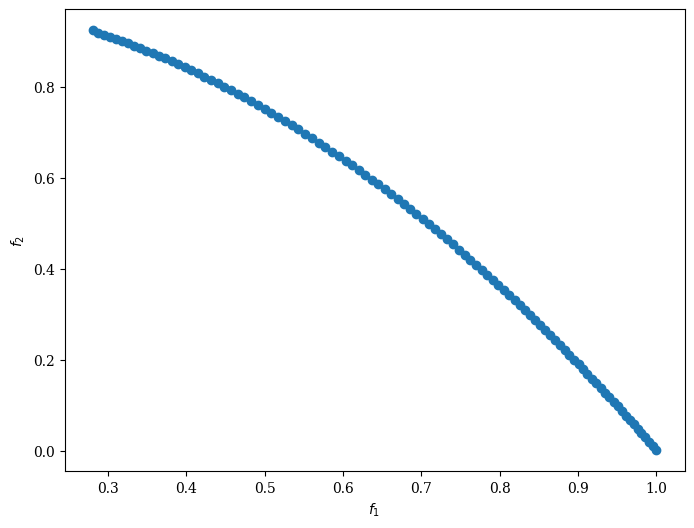

In [46]:
Scatter().add(res.F).show()

In [34]:
with open('pymoo_time_nsga3_zdt6_100_500_2_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_zdt6_100_500_2_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writerFitness.writerow(["f1","f2"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', 500), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |      100 |  0.0089318752
     2 |      200 |  0.0126392841
     3 |      300 |  0.0305666924
     4 |      400 |  0.0305666924
     5 |      500 |  0.0518441200
     6 |      600 |  0.0628235340
     7 |      700 |  0.0727961063
     8 |      800 |  0.0798542500
     9 |      900 |  0.0798542500
    10 |     1000 |  0.0954780579
    11 |     1100 |  0.1111426353
    12 |     1200 |  0.1111426353
    13 |     1300 |  0.1267716885
    14 |     1400 |  0.1308174133
    15 |     1500 |  0.1464850903
    16 |     1600 |  0.1464850903
    17 |     1700 |  0.1621091366
    18 |     1800 |  0.1621091366
    19 |     1900 |  0.1777281761
    20 |     2000 |  0.1933510303
    21 |     2100 |  0.1933510303
    22 |     2200 |  0.2089762688
    23 |     2300 |  0.2089762688
    24 |     2400 |  0.2336859703
    25 |     2500 |  0.2482059002
    26 |     2600 |  0.2571856976
    27 |     2700 |  0.2677931786
    28 |     2800 |  0.2777655125
    29 |     2

   256 |    25600 |  2.6093807220
   257 |    25700 |  2.6305484772
   258 |    25800 |  2.6325950623
   259 |    25900 |  2.6556653976
   260 |    26000 |  2.6676313877
   261 |    26100 |  2.6801416874
   262 |    26200 |  2.6901087761
   263 |    26300 |  2.6947808266
   264 |    26400 |  2.7104375362
   265 |    26500 |  2.7174878120
   266 |    26600 |  2.7331550121
   267 |    26700 |  2.7331550121
   268 |    26800 |  2.7487375736
   269 |    26900 |  2.7643566132
   270 |    27000 |  2.7643566132
   271 |    27100 |  2.7800145149
   272 |    27200 |  2.7956411839
   273 |    27300 |  2.8112211227
   274 |    27400 |  2.8202092648
   275 |    27500 |  2.8380424976
   276 |    27600 |  2.8501148224
   277 |    27700 |  2.8600871563
   278 |    27800 |  2.8631558418
   279 |    27900 |  2.8787803650
   280 |    28000 |  2.8787803650
   281 |    28100 |  2.8944458961
   282 |    28200 |  2.9100255966
   283 |    28300 |  2.9180731773
   284 |    28400 |  2.9337415695
   285 |    28